# Time Zero Analysis and Correction

This notebook uses the .h5 file data saved when running the `process_all.py` file. It looks at the time zero fitting for each dataset in the .h5 file. For example, I run the `process_all.py` file with groups of ~ 200 then I will use each data set and fit it with an error function. 

In [35]:
import numpy as np
import gued
import matplotlib.pyplot as plt

## Load Experimental Data

In [130]:
file_name = "o-ntph_data_2024-06-24.h5"
group_name = "s1"
run_number = 6

### Load individual run

In [131]:
# Read combined data
combined_I, combined_stage = gued.read_individual_run(file_name, group_name, run_number)
print("Combined I data shape:", combined_I.shape)
print("Combined stage data shape:", combined_stage.shape)

Attributes for var1_run_6: Azimuthal averaged data from run 6
Attributes for var2_run_6: Stage positions from run 6
Combined I data shape: (199, 460)
Combined stage data shape: (199,)


### Remove any additional images based on index

In [103]:
#bad_idx = np.where(combined_stage==108.81)[0]
print(np.where(combined_stage==108.81)[0])
bad_idx = [28]
print(bad_idx)
mask = np.ones(combined_stage.shape, dtype=bool)
mask[bad_idx] = False

combined_stage = combined_stage[mask]
combined_I = combined_I[mask]

[ 28  66 110 147 160 198]
[28]


## Set Up Independent variables

In [125]:
uni_stage = uni_stage = np.unique(combined_stage) # Pump-probe stage position
s_cali = 0.0226 # S calibration in experiment
#s_cali = 0.02134
#posi_0    = 154.405 # The reference T0
posi_0 = 108.61
s = np.arange(0,len(combined_I[0]))*s_cali # The Q axis
realtime = (uni_stage-posi_0)/0.15  # Delay axis in ps

## Averaging Based on Delay Position

In [126]:
stage_len = len(uni_stage);               #  Number of delays
azimuthal_data = np.ones((stage_len, len(combined_I[0]))); #  Delay dependent averaged pp images

if stage_len>20:
    prt_count = 5
else:
    prt_count = 1  
for i in range(stage_len):
    if i%prt_count == 0:
        print('Averaging data at stage posi # '+ str(i) + ', ' + str(uni_stage[i]) + ' mm') # Obtain a sub array to save the data in one delay
    stage_data = combined_I[np.where(combined_stage==uni_stage[i])[0]];
    azimuthal_data[i] = np.nanmean(stage_data,axis=0); # no subtracting background


Averaging data at stage posi # 0, 108.0 mm
Averaging data at stage posi # 5, 108.63 mm
Averaging data at stage posi # 10, 108.68 mm
Averaging data at stage posi # 15, 108.73 mm
Averaging data at stage posi # 20, 108.78 mm
Averaging data at stage posi # 25, 108.85 mm
Averaging data at stage posi # 30, 109.05 mm
Averaging data at stage posi # 35, 111.67 mm


C:\Users\laure\AppData\Local\Temp\ipykernel_22176\1352326992.py:12: RuntimeWarning: Mean of empty slice
  azimuthal_data[i] = np.nanmean(stage_data,axis=0); # no subtracting background


## Plot dI/I

Create groups to fit over, two to three peaks works well. I use three

In [127]:
if stage_len<5: # Make up the reference signals
    N_ref = 2
else:
    N_ref = 3
norm_ref = np.nanmean(azimuthal_data[:N_ref],axis=0)         # Reference signal before T0

dI_I = (azimuthal_data-norm_ref)/norm_ref # Calculate the percentage difference signal

dI_I_fit = gued.poly_fit(dI_I, s, plot=False)

# Range s values to integrate over
RoI_1 = [2.0, 2.4]
RoI_2 = [2.8, 3.1]
RoI_3 = [4.2, 4.8]

# Averaged signal within the ranges of interest
Inte_1 = np.nanmean(dI_I_fit[:,round(RoI_1[0]/s_cali):round(RoI_1[1]/s_cali)], axis=1)
Inte_2 = np.nanmean(dI_I_fit[:,round(RoI_2[0]/s_cali):round(RoI_2[1]/s_cali)], axis=1)
Inte_3 = np.nanmean(dI_I_fit[:, round(RoI_3[0]/s_cali):round(RoI_3[1]/s_cali)], axis=1)

C:\Users\laure\AppData\Local\Temp\ipykernel_22176\4286738986.py:5: RuntimeWarning: Mean of empty slice
  norm_ref = np.nanmean(azimuthal_data[:N_ref],axis=0)         # Reference signal before T0


C:\Users\laure\AppData\Local\Temp\ipykernel_22176\4087785030.py:23: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  plt.colorbar()


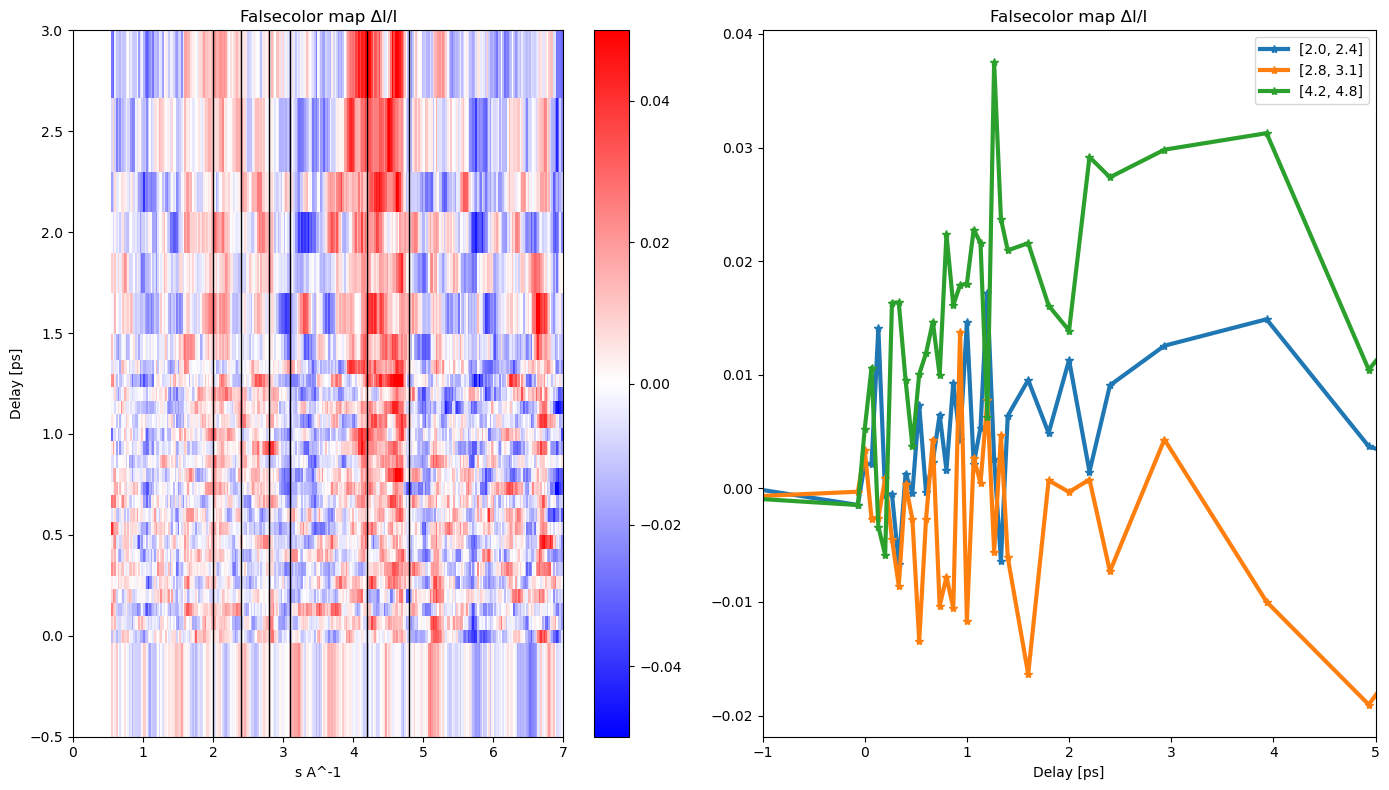

In [128]:
# Plot a figure of the time-depdendent signal of scattering percentage difference.
plt.figure(figsize=(14,8))

# plt.subplot(2,2,1)
# for i in range(stage_len):
#     if i%2 == 0:
#         plt.plot(s,dI_I_fit[stage_len-i-1] + np.nanmax(dI_I_fit)*(i)/5)
#         plt.text(s[-1]+1,np.nanmax(dI_I)*(i)/5, r'τ = {0:.2f} ps'.format(realtime[stage_len-i-1]))
#         plt.axhline(y = np.nanmax(dI_I)*(i)/5, color = 'k', linestyle = '-',linewidth=0.5)
# plt.xlabel('s A^-1')
# plt.ylabel('Scattering')
# plt.title('Waterflow ΔI/I')

plt.subplot(1,2,1)
plt.pcolor(s,realtime,dI_I_fit,cmap='bwr')
plt.axvline(x = RoI_1[0], color = 'k', linestyle = '-',linewidth=1)
plt.axvline(x = RoI_1[1], color = 'k', linestyle = '-',linewidth=1)
plt.axvline(x = RoI_2[0], color = 'k', linestyle = '-',linewidth=1)
plt.axvline(x = RoI_2[1], color = 'k', linestyle = '-',linewidth=1)
plt.axvline(x = RoI_3[0], color = 'k', linestyle = '-',linewidth=1)
plt.axvline(x = RoI_3[1], color = 'k', linestyle = '-',linewidth=1)
plt.clim(vmin=-0.05, vmax=0.05)
plt.colorbar()
plt.ylim(-0.5, 3)
plt.xlim(0, 7)
plt.xlabel('s A^-1')
plt.ylabel('Delay [ps]')
plt.title('Falsecolor map ΔI/I')

plt.subplot(1,2,2)
plt.plot(realtime, Inte_1, '-*', linewidth=3, label=str(RoI_1))
plt.plot(realtime, Inte_2, '-*', linewidth=3, label=str(RoI_2))
plt.plot(realtime, Inte_3, '-*', linewidth=3, label=str(RoI_3))
plt.xlim(-1, 5)
plt.legend()
plt.xlabel('Integrated Yield [arb.]')
plt.xlabel('Delay [ps]')
plt.title('Falsecolor map ΔI/I')

plt.tight_layout()
plt.show()


## T0 Fitting

Fit parameters: 
t_0 = 0.1778  ps +-  0.2296  ps
sigma =  1.4830 ps +-  0.7306 ps




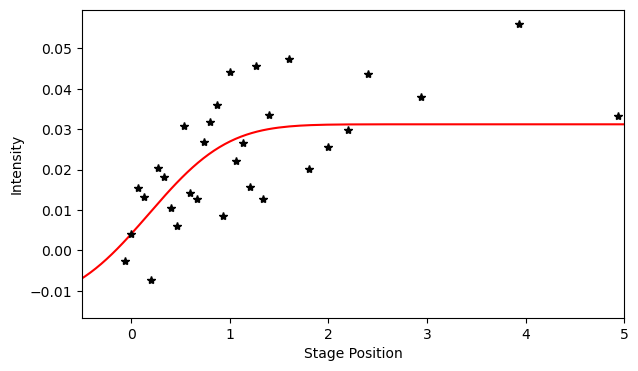

In [129]:
# ## when fitting with an error function
three_peaks = Inte_1 + (-1*Inte_2) + Inte_3


import scipy.optimize
import scipy
def equations(t, A, t0, sigma, offset): #def equations
    fit = A*(scipy.special.erf((t-t0)/(np.sqrt(2)*sigma)))+offset
    return fit

def erf_fit(t, A, B, C, D):
    fit = A*scipy.special.erf(B*t+C)+D
    return fit

# Define the error function using scipy.special.erf
def error_function(t, a, t0, sigma, offset):
    return a * scipy.special.erf((t-t0)/(sigma/(np.sqrt(2*np.log(2))))*np.sqrt(2)) + offset


# Define bounds for the parameters [amplitude, t0, sigma, offset]
bounds = ([-1, 0.0, 0, -1], [1, 1, 1.5, 0.009])  # lower bounds, upper bounds
guesses = [0.01, 0.5, 0.5, 0.0]

# # yo = equations(t, A, t0, sigma, offset) #equations
# popt, pcov, info, _, _ = curve_fit(erf_fit, uni_time[5:25], data_1[5:25], bounds=bounds, full_output=True)

# Fit the curve to the data
#popt_all, pcov_all = curve_fit(error_function, uni_stage[:], all_data[:], p0=guesses)
popt, pcov = scipy.optimize.curve_fit(error_function, realtime[:], three_peaks[:], p0=guesses, bounds=bounds)

t_new = np.linspace(realtime[0], realtime[-1], 1000)
stage_new = np.linspace(uni_stage[0], uni_stage[-1], 1000)
## error func fit
A, t0, sigma, offset = popt
#A1, t1, sigma1, offset1 = popt_all
print("Fit parameters: ")
print("=====================================================")

print("t_0 =", '%1.4f '%(popt[1]),'ps +- ','%1.4f '%np.sqrt(pcov[1,1]),"ps")
print("sigma = ", '%1.4f'%(popt[2]), 'ps +- ', '%1.4f' %np.sqrt(pcov[2,2]), "ps")

print("\n")
plt.figure(figsize=(7,4))
# plt.plot(t,yo,color=‘purple’,ls=‘--’)
plt.plot(t_new, error_function(t_new, A, t0, sigma, offset) ,color='red', label="fit")
#plt.plot(uni_time, Inte_2,'*',color='black', label="feature at s=4.0-4.5")
plt.plot(realtime, three_peaks, "*", color='black')
#plt.xlim(-1,2)
plt.xlim(-0.5, 5)
plt.xlabel("Stage Position")
plt.ylabel("Intensity")
#plt.title("UED IRF Fit")
#plt.legend()
plt.show()

# print("Fit parameters: ")
# print("=====================================================")
# print("t_0 =", '%1.4f '%(popt_all[1]),'mm +- ','%1.4f '%np.sqrt(pcov_all[1,1]),"mm")
# print("sigma = ", '%1.4f'%(popt_all[2]), 'mm +- ', '%1.4f' %np.sqrt(pcov_all[2,2]), "mm")

# plt.figure(figsize=(7,4))
# plt.plot(stage_new, error_function(stage_new, A1, t1, sigma1, offset1), color='orange')
# plt.plot(uni_stage, all_data, "*", color="green")
# plt.xlim(108.5, 109)
# plt.xlabel("Stage Position")
# plt.ylabel("Intensity")
# plt.show()